# Preparation

In [7]:
!pip install --ignore-installed opacus --no-dependencies
!git clone https://github.com/Harry24k/adversarial-attacks-pytorch.git
import sys
sys.path.insert(0,'/content/adversarial-attacks-pytorch')
import torchattacks

  Using cached opacus-0.14.0-py3-none-any.whl (114 kB)


fatal: destination path 'adversarial-attacks-pytorch' already exists and is not an empty directory.


In [8]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from opacus import PrivacyEngine
from torchvision import datasets, transforms
from tqdm import tqdm
import copy
from torch.utils.data import DataLoader
import time
import matplotlib.pyplot as plt

device=torch.device('cuda')

def epoch_test(loader, model):
    model.eval()
    total_loss, total_err = 0.,0.
    weight_set_samples=[] 
    for iter_index,(X,y) in enumerate(loader):
        X,y = X.to(device), y.to(device)
        yp = nn.LogSoftmax(dim=1)(model(X))
        loss = nn.NLLLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def epoch_adversarial_GITHUB(attack_model, loader,attack, *args):
    total_loss, total_err = 0.,0.
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        adv_image_with_delta = attack(attack_model, *args)(X,y)
        
        yp = nn.LogSoftmax(dim=1)(attack_model(adv_image_with_delta))
        
        loss = nn.NLLLoss()(yp,y)
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
        break
    return total_err / X.shape[0], total_loss / X.shape[0]

def epoch_train(loader, model,model_class,opt=None,save_snapshot=False,adversarial=False,compute_eps=False):
    model.train()
    total_loss, total_err = 0.,0.
    weight_set_samples=[] 
    for iter_index,(X,y) in enumerate(loader):
        X,y = X.to(device), y.to(device)
        if adversarial:
          # must use model copy for DP learning
          model_copy= model_class().to(device);model_copy.load_state_dict(copy.deepcopy(model.state_dict()))
          atk=torchattacks.PGD(model_copy, eps=adversarial, alpha=2.5*adversarial/20, steps=10)
          X=atk(X,y)

        yp = nn.LogSoftmax(dim=1)(model(X))
        loss = nn.NLLLoss()(yp,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        if save_snapshot!=False and iter_index%save_snapshot==0:
          weight_set_samples.append(copy.deepcopy(model.state_dict()))
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]

    if compute_eps==True:
      epsilon, _ = opt.privacy_engine.get_privacy_spent(args.delta)
      print(f"(ε = {epsilon:.2f}, δ = {args.delta})")
    return total_err / len(loader.dataset), total_loss / len(loader.dataset),weight_set_samples


def epoch_train_FGSM(loader, model,model_class,opt=None,adversarial=False,compute_eps=False):
    model.train()
    total_loss, total_err = 0.,0.
    for iter_index,(X,y) in enumerate(loader):
        X,y = X.to(device), y.to(device)
        if adversarial:
          # must use model copy for DP learning
          model_copy= model_class().to(device);model_copy.load_state_dict(copy.deepcopy(model.state_dict()))
          atk=torchattacks.FGSM(model_copy, eps=adversarial)
          X=atk(X,y)

        yp = nn.LogSoftmax(dim=1)(model(X))
        loss = nn.NLLLoss()(yp,y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        
        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    
    if compute_eps==True:
      epsilon, _ = opt.privacy_engine.get_privacy_spent(args.delta)
      print(f"(ε = {epsilon:.2f}, δ = {args.delta})")
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def epoch_train_CW(loader, model,model_class,opt=None,adversarial=False):
    model.train()
    total_loss, total_err = 0.,0.
    for iter_index,(X,y) in enumerate(loader):
        X,y = X.to(device), y.to(device)
        if adversarial:
          # must use model copy for DP learning
          model_copy= model_class().to(device);model_copy.load_state_dict(copy.deepcopy(model.state_dict()))
          atk=torchattacks.CW(model_copy, steps=100)
          X=atk(X,y)

        yp = nn.LogSoftmax(dim=1)(model(X))
        loss = nn.NLLLoss()(yp,y)
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)

def epoch_train_PGDL2(loader, model,model_class,opt=None,adversarial=False):
    model.train()
    total_loss, total_err = 0.,0.
    for iter_index,(X,y) in enumerate(loader):
        X,y = X.to(device), y.to(device)
        if adversarial:
          # must use model copy for DP learning
          model_copy= model_class().to(device);model_copy.load_state_dict(copy.deepcopy(model.state_dict()))
          atk=torchattacks.PGDL2(model_copy, eps=adversarial)
          X=atk(X,y)

        yp = nn.LogSoftmax(dim=1)(model(X))
        loss = nn.NLLLoss()(yp,y)
        opt.zero_grad()
        loss.backward()
        opt.step()

        total_err += (yp.max(dim=1)[1] != y).sum().item()
        total_loss += loss.item() * X.shape[0]
    return total_err / len(loader.dataset), total_loss / len(loader.dataset)


In [9]:
class MNISTConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 8, 2, padding=3)
        self.conv2 = nn.Conv2d(16, 32, 4, 2)
        self.fc1 = nn.Linear(32 * 4 * 4, 32)
        self.fc2 = nn.Linear(32, 10)

    def forward(self, x):
        # x of shape [B, 1, 28, 28]
        x = torch.tanh(self.conv1(x))  # -> [B, 16, 14, 14]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 16, 13, 13]
        x = torch.tanh(self.conv2(x))  # -> [B, 32, 5, 5]
        x = F.max_pool2d(x, 2, 1)  # -> [B, 32, 4, 4]
        x = x.view(-1, 32 * 4 * 4)  # -> [B, 512]
        x = torch.tanh(self.fc1(x))  # -> [B, 32]
        x = self.fc2(x)  # -> [B, 10]
        return x

    def name(self):
        return "MNISTConvNet"


# MNSIT: DP-SGD and FGSM Attacks

## FSGM attack

In [15]:
class Args:
    batch_size=300
    epochs=15
    n_runs=1
    lr=0.25
    sigma=1.3
    max_per_sample_grad_norm=1.5
    delta=1e-5
    device='cuda'
    save_model=False
    disable_dp=False
    
args = Args()
device = torch.device(args.device)

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST("../data",train=True,download=True,
                   transform=transforms.Compose(
                       [transforms.ToTensor()])# no normalization for attacks
                   ), batch_size=args.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST("../data",train=False,
                   transform=transforms.Compose(
                       [transforms.ToTensor()])
                   ), batch_size=1000, shuffle=False)


cnn_nonDP = MNISTConvNet().to(device)
opt_nonDP = optim.SGD(cnn_nonDP.parameters(), lr=args.lr)
cnn_nonDP_adv = MNISTConvNet().to(device)
opt_nonDP_adv = optim.SGD(cnn_nonDP_adv.parameters(), lr=args.lr)
cnn_DP=MNISTConvNet().to(device)
opt_DP = optim.SGD(cnn_DP.parameters(), lr=args.lr)
cnn_DP_adv=MNISTConvNet().to(device)
opt_DP_adv = optim.SGD(cnn_DP_adv.parameters(), lr=args.lr)

privacy_engine = PrivacyEngine(
    cnn_DP,
    batch_size=args.batch_size,
    sample_size=len(train_loader.dataset),
    alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
    noise_multiplier=args.sigma,
    max_grad_norm=args.max_per_sample_grad_norm,
)
privacy_engine.attach(opt_DP)

privacy_engine_adv = PrivacyEngine(
    cnn_DP_adv,
    batch_size=args.batch_size,
    sample_size=len(train_loader.dataset),
    alphas=[1 + x / 10.0 for x in range(1, 100)] + list(range(12, 64)),
    noise_multiplier=args.sigma,
    max_grad_norm=args.max_per_sample_grad_norm,
)
privacy_engine_adv.attach(opt_DP_adv)

test_err_nonDP_record,test_loss_nonDP_record=[],[]
test_err_nonDP_record_adv,test_loss_nonDP_record_adv=[],[]
test_err_nonDP_adv_record,test_loss_nonDP_adv_record=[],[]
test_err_nonDP_adv_record_adv,test_loss_nonDP_adv_record_adv=[],[]
test_err_DP_record,test_loss_DP_record=[],[]
test_err_DP_record_adv,test_loss_DP_record_adv=[],[]
test_err_DP_adv_record,test_loss_DP_adv_record=[],[]
test_err_DP_adv_record_adv,test_loss_DP_adv_record_adv=[],[]

for Epoch in range(args.epochs):
    ### only save last epoch snapshots
    train_err_nonDP, train_loss_nonDP = epoch_train_FGSM(train_loader, cnn_nonDP,MNISTConvNet, opt_nonDP)
    test_err_nonDP, test_loss_nonDP = epoch_test(test_loader, cnn_nonDP)
    test_err_nonDP_record.append(test_err_nonDP)
    test_loss_nonDP_record.append(test_loss_nonDP)
    print('Epoch',Epoch,'--> nonDP:',*("{:.6f}".format(i) for i in (1-train_err_nonDP, train_loss_nonDP, 1-test_err_nonDP, test_loss_nonDP)), sep="\t" )
    a,b=epoch_adversarial_GITHUB(cnn_nonDP, test_loader, torchattacks.FGSM, 0.1)
    test_err_nonDP_record_adv.append(a)
    test_loss_nonDP_record_adv.append(b)
    print('Robust accuracy:',1-a,b)

    train_err_nonDP_adv, train_loss_nonDP_adv = epoch_train_FGSM(train_loader, cnn_nonDP_adv,MNISTConvNet, opt_nonDP_adv,adversarial=0.1)
    test_err_nonDP_adv, test_loss_nonDP_adv = epoch_test(test_loader, cnn_nonDP_adv)
    test_err_nonDP_adv_record.append(test_err_nonDP_adv)
    test_loss_nonDP_adv_record.append(test_loss_nonDP_adv)
    print('Epoch',Epoch,'--> nonDP_adv:',*("{:.6f}".format(i) for i in (1-train_err_nonDP_adv, train_loss_nonDP_adv, 1-test_err_nonDP_adv, test_loss_nonDP_adv)), sep="\t")
    a,b=epoch_adversarial_GITHUB(cnn_nonDP_adv, test_loader, torchattacks.FGSM, 0.1)
    test_err_nonDP_adv_record_adv.append(a)
    test_loss_nonDP_adv_record_adv.append(b)
    print('Robust accuracy:',1-a,b)

    train_err_DP, train_loss_DP = epoch_train_FGSM(train_loader, cnn_DP,MNISTConvNet, opt_DP,compute_eps=True)
    test_err_DP, test_loss_DP = epoch_test(test_loader, cnn_DP)
    test_err_DP_record.append(test_err_DP)
    test_loss_DP_record.append(test_loss_DP)
    print('Epoch',Epoch,'--> DP:',*("{:.6f}".format(i) for i in (1-train_err_DP, train_loss_DP, 1-test_err_DP, test_loss_DP)), sep="\t")
    cnn_DP_copy = MNISTConvNet().to(device);cnn_DP_copy.load_state_dict(copy.deepcopy(cnn_DP.state_dict()))    
    a,b=epoch_adversarial_GITHUB(cnn_DP_copy, test_loader, torchattacks.FGSM, 0.1)
    test_err_DP_record_adv.append(a)
    test_loss_DP_record_adv.append(b)
    print('Robust accuracy:',1-a,b)
    
    train_err_DP_adv, train_loss_DP_adv = epoch_train_FGSM(train_loader, cnn_DP_adv,MNISTConvNet, opt_DP_adv,adversarial=0.1,compute_eps=True)
    test_err_DP_adv, test_loss_DP_adv = epoch_test(test_loader, cnn_DP_adv)
    test_err_DP_adv_record.append(test_err_DP_adv)
    test_loss_DP_adv_record.append(test_loss_DP_adv)
    print('Epoch',Epoch,'--> DP-Adv:',*("{:.6f}".format(i) for i in (1-train_err_DP_adv, train_loss_DP_adv, 1-test_err_DP_adv, test_loss_DP_adv)), sep="\t")
    cnn_DP_copy_adv = MNISTConvNet().to(device);cnn_DP_copy_adv.load_state_dict(copy.deepcopy(cnn_DP_adv.state_dict()))
    a,b=epoch_adversarial_GITHUB(cnn_DP_copy_adv, test_loader, torchattacks.FGSM, 0.1)
    test_err_DP_adv_record_adv.append(a)
    test_loss_DP_adv_record_adv.append(b)
    print('Robust accuracy:',1-a,b)
    

/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:639: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  "The sample rate will be defined from ``batch_size`` and ``sample_size``."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:230: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_rng`` turned on.
  "Secure RNG turned off. This is perfectly fine for experimentation as it allows "
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engine.py:639: UserWarning: The sample rate will be defined from ``batch_size`` and ``sample_size``.The returned privacy budget will be incorrect.
  "The sample rate will be defined from ``batch_size`` and ``sample_size``."
/usr/local/lib/python3.7/dist-packages/opacus/privacy_engin

Epoch	0	--> nonDP:	0.855367	0.540751	0.966800	0.128374
Robust accuracy: 0.6739999999999999 0.984422504901886
Epoch	0	--> nonDP_adv:	0.647450	1.044916	0.969200	0.136894
Robust accuracy: 0.849 0.4388977885246277


/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:974: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


(ε = 0.52, δ = 1e-05)
Epoch	0	--> DP:	0.698333	1.132132	0.874000	0.435374
Robust accuracy: 0.44899999999999995 1.6856250762939453
(ε = 0.52, δ = 1e-05)
Epoch	0	--> DP-Adv:	0.372983	1.839950	0.829200	0.766138
Robust accuracy: 0.556 1.2090179920196533
Epoch	1	--> nonDP:	0.969050	0.110172	0.977900	0.075665
Robust accuracy: 0.7050000000000001 0.9551315307617188
Epoch	1	--> nonDP_adv:	0.891017	0.342601	0.975200	0.090728
Robust accuracy: 0.874 0.35775744915008545
(ε = 0.56, δ = 1e-05)
Epoch	1	--> DP:	0.895767	0.350924	0.922600	0.259914
Robust accuracy: 0.538 1.6164039373397827
(ε = 0.56, δ = 1e-05)
Epoch	1	--> DP-Adv:	0.658500	0.962048	0.913100	0.344448
Robust accuracy: 0.696 0.8753436803817749
Epoch	2	--> nonDP:	0.977533	0.077041	0.982300	0.059952
Robust accuracy: 0.663 1.072165608406067
Epoch	2	--> nonDP_adv:	0.919300	0.250952	0.984800	0.057378
Robust accuracy: 0.911 0.2533731758594513
(ε = 0.60, δ = 1e-05)
Epoch	2	--> DP:	0.926233	0.246890	0.941500	0.198979
Robust accuracy: 0.574000000000

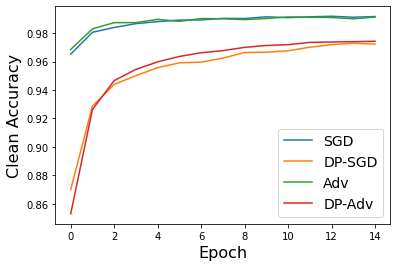

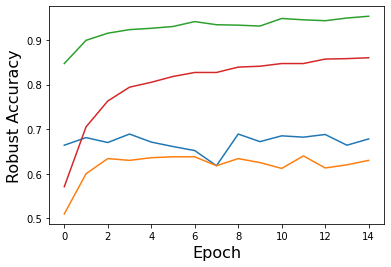

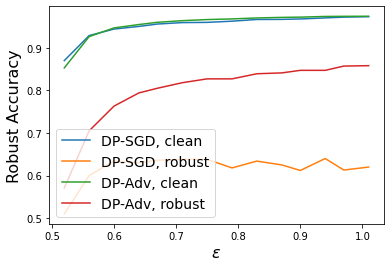

In [ ]:
import matplotlib.pyplot as plt
plt.plot([1-i for i in test_err_nonDP_record],label='SGD')
plt.plot([1-i for i in test_err_DP_record],label='DP-SGD')
plt.plot([1-i for i in test_err_nonDP_adv_record],label='Adv')
plt.plot([1-i for i in test_err_DP_adv_record],label='DP-Adv')
plt.legend(fontsize=14)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Clean Accuracy',fontsize=16)
plt.show()


plt.plot([1-i for i in test_err_nonDP_record_adv],label='SGD')
plt.plot([1-i for i in test_err_DP_record_adv],label='DP-SGD')
plt.plot([1-i for i in test_err_nonDP_adv_record_adv],label='Adv')
plt.plot([1-i for i in test_err_DP_adv_record_adv],label='DP-Adv')
# plt.legend(fontsize=14)
plt.xlabel('Epoch',fontsize=16)
plt.ylabel('Robust Accuracy',fontsize=16)
plt.show()


EPS=[0.52,0.56,0.6,0.64,0.67,0.71,0.75,0.79,0.83,0.87,0.9,0.94,0.97,1.01]
plt.plot(EPS,[1-i for i in test_err_DP_record[:-1]],label='DP-SGD, clean')
plt.plot(EPS,[1-i for i in test_err_DP_record_adv[:-1]],label='DP-SGD, robust')
plt.plot(EPS,[1-i for i in test_err_DP_adv_record[:-1]],label='DP-Adv, clean')
plt.plot(EPS,[1-i for i in test_err_DP_adv_record_adv[:-1]],label='DP-Adv, robust')
plt.legend(loc='lower left',fontsize=14)
plt.xlabel(r'$\epsilon$',fontsize=16)
plt.ylabel('Robust Accuracy',fontsize=16)
plt.show()

# MNIST transferability

## FGSM weights

In [ ]:
print(1-epoch_adversarial_GITHUB(cnn_nonDP, test_loader, torchattacks.FGSM,None,1,0.1)[0])
print(1-epoch_adversarial_GITHUB(cnn_nonDP, test_loader, torchattacks.PGD,None,1,0.1,0.01,20)[0])
print(1-epoch_adversarial_GITHUB(cnn_nonDP, test_loader, torchattacks.BIM,None,1,0.1)[0])
print(1-epoch_adversarial_GITHUB(cnn_nonDP, test_loader, torchattacks.APGD,None,1,'Linf',0.1)[0])
print(1-epoch_adversarial_GITHUB(cnn_nonDP, test_loader, torchattacks.AutoAttack,None,1,'Linf',0.1)[0])
# print(1-epoch_adversarial_GITHUB(cnn_nonDP, test_loader, torchattacks.CW,None,1,1)[0])
print(1-epoch_adversarial_GITHUB(cnn_nonDP, test_loader, torchattacks.PGDL2,None,1,1)[0])
print(1-epoch_adversarial_GITHUB(cnn_nonDP, test_loader, torchattacks.APGD,None,1,'L2',1)[0])
print(1-epoch_adversarial_GITHUB(cnn_nonDP, test_loader, torchattacks.AutoAttack,None,1,'L2',1)[0])

0.6779999999999999
0.32999999999999996
0.406
0.28900000000000003
0.271
0.631
0.616
0.6


In [ ]:
print(1-epoch_adversarial_GITHUB(cnn_DP, test_loader, torchattacks.FGSM,None,1,0.1)[0])
print(1-epoch_adversarial_GITHUB(cnn_DP, test_loader, torchattacks.PGD,None,1,0.1,0.01,20)[0])
print(1-epoch_adversarial_GITHUB(cnn_DP, test_loader, torchattacks.BIM,None,1,0.1)[0])
print(1-epoch_adversarial_GITHUB(cnn_DP, test_loader, torchattacks.APGD,None,1,'Linf',0.1)[0])
print(1-epoch_adversarial_GITHUB(cnn_DP, test_loader, torchattacks.AutoAttack,None,1,'Linf',0.1)[0])
# print(1-epoch_adversarial_GITHUB(cnn_DP, test_loader, torchattacks.CW,None,1)[0])
print(1-epoch_adversarial_GITHUB(cnn_DP, test_loader, torchattacks.PGDL2,None,1,1)[0])
print(1-epoch_adversarial_GITHUB(cnn_DP, test_loader, torchattacks.APGD,None,1,'L2',1)[0])
print(1-epoch_adversarial_GITHUB(cnn_DP, test_loader, torchattacks.AutoAttack,None,1,'L2',1)[0])

0.63
0.28
0.369
0.20599999999999996
0.18700000000000006
0.963
0.527
0.518
0.498


In [ ]:
print(1-epoch_adversarial_GITHUB(cnn_nonDP_adv, test_loader, torchattacks.FGSM,None,1,0.1)[0])
print(1-epoch_adversarial_GITHUB(cnn_nonDP_adv, test_loader, torchattacks.PGD,None,1,0.1,0.01,20)[0])
print(1-epoch_adversarial_GITHUB(cnn_nonDP_adv, test_loader, torchattacks.BIM,None,1,0.1)[0])
print(1-epoch_adversarial_GITHUB(cnn_nonDP_adv, test_loader, torchattacks.APGD,None,1,'Linf',0.1)[0])
print(1-epoch_adversarial_GITHUB(cnn_nonDP_adv, test_loader, torchattacks.AutoAttack,None,1,'Linf',0.1)[0])
# print(1-epoch_adversarial_GITHUB(cnn_nonDP_adv, test_loader, torchattacks.CW,None,1)[0])
print(1-epoch_adversarial_GITHUB(cnn_nonDP_adv, test_loader, torchattacks.PGDL2,None,1,1)[0])
print(1-epoch_adversarial_GITHUB(cnn_nonDP_adv, test_loader, torchattacks.APGD,None,1,'L2',1)[0])
print(1-epoch_adversarial_GITHUB(cnn_nonDP_adv, test_loader, torchattacks.AutoAttack,None,1,'L2',1)[0])

0.953
0.924
0.931
0.922
0.919
0.989
0.901
0.902
0.9


In [ ]:
print(1-epoch_adversarial_GITHUB(cnn_DP_adv, test_loader, torchattacks.FGSM,None,1,0.1)[0])
print(1-epoch_adversarial_GITHUB(cnn_DP_adv, test_loader, torchattacks.PGD,None,1,0.1,0.01,20)[0])
print(1-epoch_adversarial_GITHUB(cnn_DP_adv, test_loader, torchattacks.BIM,None,1,0.1)[0])
print(1-epoch_adversarial_GITHUB(cnn_DP_adv, test_loader, torchattacks.APGD,None,1,'Linf',0.1)[0])
print(1-epoch_adversarial_GITHUB(cnn_DP_adv, test_loader, torchattacks.AutoAttack,None,1,'Linf',0.1)[0])
# print(1-epoch_adversarial_GITHUB(cnn_DP_adv, test_loader, torchattacks.CW,None,1)[0])
print(1-epoch_adversarial_GITHUB(cnn_DP_adv, test_loader, torchattacks.PGDL2,None,1,1)[0])
print(1-epoch_adversarial_GITHUB(cnn_DP_adv, test_loader, torchattacks.APGD,None,1,'L2',1)[0])
print(1-epoch_adversarial_GITHUB(cnn_DP_adv, test_loader, torchattacks.AutoAttack,None,1,'L2',1)[0])

0.86
0.8
0.815
0.784
0.783
0.966
0.8220000000000001
0.8200000000000001
0.8160000000000001


# MNIST calibration

## FGSM weights

100%|██████████| 10/10 [00:00<00:00, 12.90it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


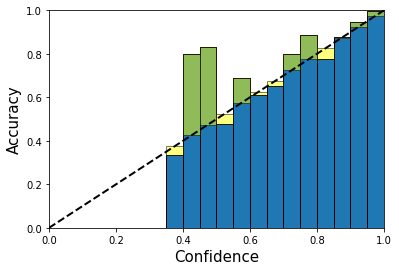

Local ECE: 0.0962447529351361
Local MCE: 0.375
Local accuracy: 0.9917, predicted confidence 0.9901519007205963


In [ ]:
model_local=cnn_nonDP
model_local.eval()
y_local_te=np.empty((0,10))
y_local_te_single=np.array([])
targets_te=np.array([])
prob_local=np.array([])
with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model_local(data)
            y_local_te=np.append(y_local_te,F.softmax(output,dim=1).cpu().detach().numpy(),axis=0)
            y_local_te_single=np.append(y_local_te_single,F.softmax(output,dim=1).argmax(dim=1).cpu().detach().numpy())
            prob_local=np.append(prob_local,np.array([F.softmax(output,dim=1).cpu().detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy()) if j==7]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())

local_acc = np.mean(y_local_te_single == targets_te)


store_local=[]
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))
    
# some has nan, replace with 0
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0
#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.show()

print(f"Local ECE: {np.mean(np.abs(xaxis[store_local!=0]-store_local[store_local!=0]))}")
print(f"Local MCE: {np.max(np.abs(xaxis[store_local!=0]-store_local[store_local!=0]))}")
print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}")


100%|██████████| 10/10 [00:00<00:00, 12.95it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


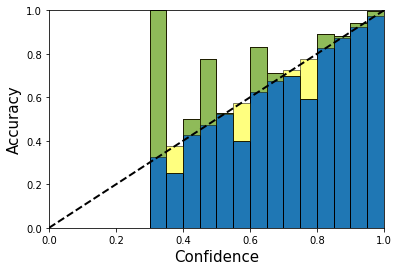

Local ECE: 0.13680526948529956
Local MCE: 0.6749999999999999
Local accuracy: 0.9913, predicted confidence 0.9889053715735674


In [ ]:
model_local=cnn_nonDP_adv
model_local.eval()
y_local_te=np.empty((0,10))
y_local_te_single=np.array([])
targets_te=np.array([])
prob_local=np.array([])
with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model_local(data)
            y_local_te=np.append(y_local_te,F.softmax(output,dim=1).cpu().detach().numpy(),axis=0)
            y_local_te_single=np.append(y_local_te_single,F.softmax(output,dim=1).argmax(dim=1).cpu().detach().numpy())
            prob_local=np.append(prob_local,np.array([F.softmax(output,dim=1).cpu().detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy()) if j==7]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())

local_acc = np.mean(y_local_te_single == targets_te)


store_local=[]
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))
    
# some has nan, replace with 0
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0
#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.show()

print(f"Local ECE: {np.mean(np.abs(xaxis[store_local!=0]-store_local[store_local!=0]))}")
print(f"Local MCE: {np.max(np.abs(xaxis[store_local!=0]-store_local[store_local!=0]))}")
print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}")


100%|██████████| 10/10 [00:00<00:00, 11.57it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


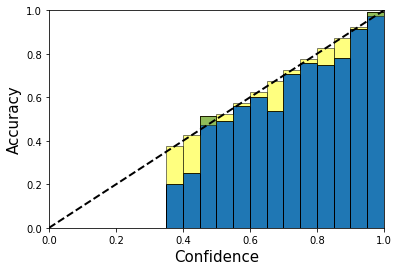

Local ECE: 0.06432147286889306
Local MCE: 0.17500000000000004
Local accuracy: 0.9723, predicted confidence 0.978778334081173


In [ ]:
model_local=cnn_DP
model_local.eval()
y_local_te=np.empty((0,10))
y_local_te_single=np.array([])
targets_te=np.array([])
prob_local=np.array([])
with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model_local(data)
            y_local_te=np.append(y_local_te,F.softmax(output,dim=1).cpu().detach().numpy(),axis=0)
            y_local_te_single=np.append(y_local_te_single,F.softmax(output,dim=1).argmax(dim=1).cpu().detach().numpy())
            prob_local=np.append(prob_local,np.array([F.softmax(output,dim=1).cpu().detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy()) if j==7]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())

local_acc = np.mean(y_local_te_single == targets_te)


store_local=[]
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))
    
# some has nan, replace with 0
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0
#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.show()

print(f"Local ECE: {np.mean(np.abs(xaxis[store_local!=0]-store_local[store_local!=0]))}")
print(f"Local MCE: {np.max(np.abs(xaxis[store_local!=0]-store_local[store_local!=0]))}")
print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}")


100%|██████████| 10/10 [00:00<00:00, 13.64it/s]
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.7/dist-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


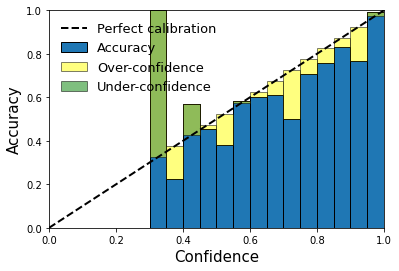

Local ECE: 0.13002036958966032
Local MCE: 0.6749999999999999
Local accuracy: 0.9743, predicted confidence 0.9832324415802955


In [ ]:
model_local=cnn_DP_adv
model_local.eval()
y_local_te=np.empty((0,10))
y_local_te_single=np.array([])
targets_te=np.array([])
prob_local=np.array([])
with torch.no_grad():
        for data, target in tqdm(test_loader):
            data, target = data.to(device), target.to(device)
            output = model_local(data)
            y_local_te=np.append(y_local_te,F.softmax(output,dim=1).cpu().detach().numpy(),axis=0)
            y_local_te_single=np.append(y_local_te_single,F.softmax(output,dim=1).argmax(dim=1).cpu().detach().numpy())
            prob_local=np.append(prob_local,np.array([F.softmax(output,dim=1).cpu().detach().numpy()[i,j] for i,j in enumerate(target.cpu().detach().numpy()) if j==7]))
            targets_te=np.append(targets_te,target.cpu().detach().numpy())

local_acc = np.mean(y_local_te_single == targets_te)


store_local=[]
templ=np.max(y_local_te,axis=1)
dr=0.05
for ratio in np.arange(0,1,dr):
    index=(templ>ratio)*(templ<ratio+dr)
    store_local.append(np.mean(y_local_te_single[index]==targets_te[index]))
    
# some has nan, replace with 0
store_local=np.array(store_local)
store_local[np.isnan(store_local)]=0
#%%
xaxis=np.arange(0,1,dr)+dr/2
plt.bar(xaxis[store_local!=0],store_local[store_local!=0],width=dr, edgecolor="black")
plt.bar(xaxis[store_local!=0],xaxis[store_local!=0]-store_local[store_local!=0],bottom=store_local[store_local!=0],width=dr, edgecolor="black",color='yellow',alpha=0.5)
plt.bar(10,10,bottom=store_local,width=dr, edgecolor="black",color='green',alpha=0.5)
plt.plot([0,1],[0,1],color='black',linewidth=2,linestyle='dashed')
plt.xlim(0,1)
plt.ylim(0,1)
plt.xlabel('Confidence', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend(('Perfect calibration','Accuracy','Over-confidence','Under-confidence'),fontsize=13,frameon=0)
plt.show()

print(f"Local ECE: {np.mean(np.abs(xaxis[store_local!=0]-store_local[store_local!=0]))}")
print(f"Local MCE: {np.max(np.abs(xaxis[store_local!=0]-store_local[store_local!=0]))}")
print(f"Local accuracy: {local_acc}, predicted confidence {np.mean(np.max(y_local_te,axis=1))}")
